# Dreaming with sparse autoencoder features

T. Ben Thompson  
2024-10-14

I get a lot of questions about dreaming/feature visualization applied to
sparse autoencoders (SAEs) [1]. When we were writing [Fluent dreaming
for language model](https://arxiv.org/abs/2402.01702) and [the companion
post for that paper](https://confirmlabs.org/posts/dreamy.html), we
thought that a natural application of feature visualization would be
sparse autoencoder features because the features should be fairly
monosemantic. But there weren’t any open source SAE features yet and we
didn’t want to put the effort in to train our own SAE features.

Since then, several open source SAEs have been released
[\[1\]](#ref-bloom2024gpt2residualsaes),
[\[2\]](#ref-lieberum2024gemmascopeopensparse). This post will
demonstrate dreaming applied to SAE features. Technically, this is an
extremely simple modification because an SAE encoder or decoder feature
is just a direction in activation space.

In addition, since writing the dreaming paper, [we have worked on state
of the art token optimization
methods](https://confirmlabs.org/posts/flrt.html)
[\[3\]](#ref-thompson2024flrtfluentstudentteacherredteaming). I use
these new token optimization methods here.

The rest of this post is a self-contained notebook for feature
visualization of SAE features [2].

## Setup

In this first section, we setup our environment and define a few useful
functions:

-   `add_fwd_hooks` is a context manager for adding forward hooks to a
    model so that we can store and later access intermediate
    activations.
-   `load_sae` loads a Gemma Scope SAE for the specified layer.
-   `calc_xe` calculates a batched cross-entropy loss for the purpose of
    fluency scoring.

[1] As a specific motivation for this post, Joseph Bloom recently got in
touch to ask about applying feature visualization techniques to SAEs. I
wrote this with him in mind.

[2] As a disclaimer, the code below has not been heavily used and was
written just for this post. I expect inefficiences and possibly some
bugs.

In [2]:
import random
import time

import numpy as np
import sae_lens
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")
# While we will use gradients later, we don't need them for most operations and
# will explicitly enable gradients when needed.
torch.set_grad_enabled(False)

In [3]:
import contextlib
from typing import Callable, List, Tuple


@contextlib.contextmanager
def add_fwd_hooks(module_hooks: List[Tuple[torch.nn.Module, Callable]]):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()


sae_cache = {}


def load_sae(layer):
    sae_id = f"layer_{layer}/width_16k/canonical"
    if sae_id not in sae_cache:
        sae, _, _ = sae_lens.SAE.from_pretrained(
            release="gemma-scope-2b-pt-res-canonical",
            sae_id=sae_id,
            device="cuda",
        )
        sae_cache[sae_id] = sae
    else:
        sae = sae_cache[sae_id]
    return sae


def calc_xe(logits, input_ids):
    return (
        torch.nn.functional.cross_entropy(
            logits[:, :-1].reshape(-1, logits.shape[-1]),
            input_ids[:, 1:].reshape(-1),
            reduction="none",
        )
        .reshape((logits.shape[0], -1))
        .mean(dim=-1)
    )


## Dreaming

This section defines a `dream` function for optimizing token sequences
to maximize a provided feature.

Broadly, the algorithm works as follows:

1.  Mutate the current token sequence into `explore` new sequences.
2.  Evaluate the feature activation and fluency of the new sequences.
3.  Retain the best sequences.
4.  Repeat.

The most important parameter is `get_feature_and_logits`. This function
should accept a batch of sequences and return the target feature as well
as the full logits tensor from calling the model. In the next section,
we will provide a few examples of how to use this function with SAEs.

Follow along with the code comments for more detail.

``` python
def dream(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    # This function accepts a batch of sequences and returns the target feature
    # as well as the full logits tensor from calling the model.
    get_feature_and_logits: Callable,
    init_prompt: str = "help! are you a purple bobcat?",
    verbose: bool = True,  # Print status updates.
    iters: int = 500,  # Number of iterations
    seed: int = 0,
    #
    # There are two approaches to fluency control:
    # 1. `xe_max` sets an absolute limit on the cross-entropy loss.
    # 2. `xe_regularization` adds a cross-entropy fluency penalty to the loss
    #    function.
    xe_max: float = None,
    xe_regularization: float = 0.0,
    buffer_size: int = 4,  # Number of prompts to keep in the buffer
    #
    # Parameters for choosing the type of mutation operation at each iteration.
    min_tokens: int = 8,  # Minimum allowed number of tokens
    max_tokens: int = 16,  # Maximum allowed number of tokens
    p_gcg_swap: float = 0.25,  # prob of an iteration being a gcg swap
    p_sample_insert: float = 0.25,  # prob of an iteration being a sampled insert
    p_sample_swap: float = 0.25,  # prob of an iteration being a sampled swap
    p_delete: float = 0.25,  # prob of an iteration being a delete
    #
    # Mutation parameters:
    # - `sample_k2`: For sampled mutations, we sample without
    #   replacement`sample_k2` candidate tokens per token position.
    # - `gcg_topk`: For GCG, we select swap tokens from the top `gcg_topk`
    #   tokens according to the loss gradient.
    # after sampling, we have a (n_tokens, k2 or gcg_topk) matrix of candidate tokens
    # then, for each child candidate, we sample a random entry from this matrix
    # and perform the corresponding mutation.
    sample_k2: int = 16,
    gcg_topk: int = 512,
    explore: int = 128,  # Number of child candidates per parent
):
    # Set random seeds.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # We track the best prompts in a buffer. At each step, we remove the best
    # prompt and mutate it to produce new candidates. Then, we merge those
    # candidates back into the buffer.
    buffer_prompts = [init_prompt] * buffer_size
    buffer_losses = torch.tensor([float("inf")] * buffer_size)

    # Track the history of the best prompts in run.
    history = []

    for IT in range(iters):
        start = time.time()

        # At each step, we choose randomly between the four types of
        # operations. See below for precise descriptions of these operations.
        operation_idx = torch.multinomial(
            torch.tensor([p_gcg_swap, p_sample_insert, p_sample_swap, p_delete]), 1
        ).item()
        operation = ["gcg_swap", "sample_insert", "sample_swap", "delete"][
            operation_idx
        ]

        input_ids = tokenizer.encode(
            buffer_prompts[0], return_tensors="pt", add_special_tokens=False
        )

        # If the prompt is too short or too long, we force a different
        # operation.
        n_tokens = input_ids.shape[1]
        if n_tokens < min_tokens:
            operation = "sample_insert"
        elif n_tokens > max_tokens:
            operation = "delete"

        if operation == "gcg_swap":
            #########################
            # GCG SWAP
            #########################
            # A GCG swap proceeds as in Zou et al 2023:
            # - we backpropagate the loss to get the gradient of the loss with
            #   respect to each token in each token position
            # - we select the top K tokens in each position according to the loss gradient
            # - we sample uniformly at random between the token positions
            # - we sample uniformly among the top K tokens in each position
            with torch.enable_grad():
                embed = model.model.embed_tokens
                one_hot = torch.nn.functional.one_hot(
                    input_ids.clone(), num_classes=embed.num_embeddings
                ).to(embed.weight.dtype)
                one_hot.requires_grad = True
                embeds = torch.matmul(one_hot, embed.weight)
                feature, logits = get_feature_and_logits(inputs_embeds=embeds)
                (-feature).backward()

                topk_grad = (-one_hot.grad).topk(k=gcg_topk, dim=-1)
                token_pos = torch.randint(0, input_ids.shape[1], (explore,))
                topk_idx = torch.randint(0, gcg_topk, (explore,))
                candidate_ids = input_ids[0, None, :].repeat(explore, 1)
                candidate_ids[torch.arange(explore), token_pos] = topk_grad.indices[
                    0, token_pos, topk_idx
                ]
        elif operation == "sample_insert":
            ##################
            # SAMPLE INSERT
            ##################
            # A sample insert proceeds similarly to the mutation operation from
            # the BEAST paper (Sadasivan et al 2024) but incorporates features from GCG:
            # - we produce the next token probability distribution for each token position.
            # - we sample K tokens without replacement from the probability
            #   distribution for each token position.
            # - we select uniformly at random from the token positions.
            # - then we sample uniformly at random from those K tokens.
            logits = model(input_ids=input_ids).logits
            probs = torch.softmax(logits[0], dim=-1)
            candidate_ids = torch.empty((explore, n_tokens + 1), dtype=torch.long)
            insert_position = torch.randint(1, n_tokens + 1, (explore,))
            insert_probs = probs[insert_position - 1]
            sampled_ids = torch.multinomial(insert_probs, num_samples=sample_k2)
            sample_idx = torch.randint(0, sample_k2, (explore,))
            insert_ids = sampled_ids[torch.arange(explore), sample_idx]
            for j in range(explore):
                candidate_ids[j, : insert_position[j]] = input_ids[
                    0, : insert_position[j]
                ]
                candidate_ids[j, insert_position[j]] = insert_ids[j]
                candidate_ids[j, insert_position[j] + 1 :] = input_ids[
                    0, insert_position[j] :
                ]
        elif operation == "sample_swap":
            #################
            # SAMPLE SWAP
            #################
            # A sample swap proceeds similarly to the sample insert operation
            # except that we swap a token instead of inserting a new token.
            logits = model(input_ids).logits
            probs = torch.softmax(logits[0], dim=-1)
            candidate_ids = input_ids[0, None, :].repeat(explore, 1)
            swap_position = torch.randint(1, n_tokens, (explore,))
            swap_probs = probs[swap_position]
            sampled_ids = torch.multinomial(swap_probs, num_samples=sample_k2)
            sample_idx = torch.randint(0, sample_k2, (explore,))
            swap_ids = sampled_ids[torch.arange(explore), sample_idx]
            candidate_ids[torch.arange(explore), swap_position] = swap_ids
        elif operation == "delete":
            #################
            # DELETE
            #################
            # A delete operation removes a token from the prompt.
            # The set of candidates is the set of all possible deletions.
            if explore > n_tokens:
                n_candidates = n_tokens
                delete_indices = torch.arange(n_tokens)
            else:
                n_candidates = explore
                delete_indices = torch.randperm(n_tokens)[:n_candidates]

            candidate_ids = torch.empty((n_candidates, n_tokens - 1), dtype=torch.long)
            for i in range(n_candidates):
                candidate_ids[i, : delete_indices[i]] = input_ids[
                    0, : delete_indices[i]
                ]
                candidate_ids[i, delete_indices[i] :] = input_ids[
                    0, delete_indices[i] + 1 :
                ]

        # To avoid issues with special tokens, we decode and re-encode.
        candidates = tokenizer.batch_decode(candidate_ids, skip_special_tokens=True)
        candidates_tokenized = tokenizer(candidates, padding=True, return_tensors="pt")

        ################
        # Calculate loss
        ################
        feature, logits = get_feature_and_logits(**candidates_tokenized)
        xe = calc_xe(logits, candidates_tokenized["input_ids"])
        # We maximize activation, so negate activation.
        candidate_losses = -feature + xe_regularization * xe
        if xe_max is not None:
            candidate_losses = torch.where(xe > xe_max, float("inf"), candidate_losses)
        best_idx = torch.argmin(candidate_losses)

        #########################
        # Update the top-N buffer
        #########################
        # Update the top-N buffer. We remove the first element because we used it
        # up this iteration. Then, we select the top-N best sequences between the
        # existing buffer entries and the new candidates.
        combined_prompts = buffer_prompts[1:] + candidates
        combined_losses = torch.cat([buffer_losses[1:], candidate_losses])
        keep_idxs = torch.argsort(combined_losses)[:buffer_size]
        buffer_prompts = [combined_prompts[i] for i in keep_idxs]
        buffer_losses = combined_losses[keep_idxs]

        # Report on the step and record the history.
        runtime = time.time() - start
        if verbose:
            print("\n\n")
            print(f"Iteration {IT} | Operation: {operation}")
            print(
                f"Loss={candidate_losses[best_idx].item():.2f}"
                f" | Activation={feature[best_idx].item():.2f}"
                f" | XE={xe[best_idx].item():.2f}"
            )
            print(f"Runtime={runtime:.2f}s")
            print(f"Best candidate: {buffer_prompts[0]}")
        history.append(
            dict(
                operation=operation,
                runtime=runtime,
                activation=feature[best_idx].item(),
                xe=xe[best_idx].item(),
                seq=buffer_prompts[0],
            )
        )
    return history
```

## Dreaming encoder directions

In this section, we will run feature visualization on a particular SAE
encoder direction.

First, we’ll load up Gemma 2 2B.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-2b", clean_up_tokenization_spaces=False
)
gemma2 = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="cuda",
    attn_implementation="flash_attention_2",
)
gemma2 = gemma2.requires_grad_(False)

Then we’ll define a function for getting the activation of the
particular SAE latent. Importantly, we’ll grab the latent before it is
passed through the ReLU activation function or any other thresholding
operation. That will make optimization easier. The generated `f`
function will be passed as the `get_feature_and_logits` argument to the
`dream` function.

In [6]:
def gemma_sae_encoder(gemma2, layer, feature_idx):
    def f(input_ids=None, inputs_embeds=None, attention_mask=None):
        out = {}

        def get_res(module, input, output):
            out["res"] = input[0]

        model_hooks = [
            (gemma2.model.layers[layer], get_res),
        ]
        with add_fwd_hooks(model_hooks):
            if inputs_embeds is not None:
                logits = gemma2(
                    inputs_embeds=inputs_embeds, attention_mask=attention_mask
                ).logits
            else:
                logits = gemma2(
                    input_ids=input_ids, attention_mask=attention_mask
                ).logits

        def get_sae_pre(module, input, output):
            out["sae_pre"] = input[0]

        sae = load_sae(layer)
        sae_hooks = [(sae.hook_sae_acts_pre, get_sae_pre)]
        with add_fwd_hooks(sae_hooks):
            sae.encode(out["res"])

        return out["sae_pre"][:, -1, feature_idx], logits

    return f

Let’s look at layer 12, feature 0. Looking at neuronpedia, this feature
seems to respond strongly to variants of the word “label”. We run a
bunch of examples through the SAE and see how they score:

In [7]:
layer = 12
feature_idx = 0
for text in [
    "label",
    "labl",
    "LBL",
    "lbl",
    "LABEL",
    "labal",
    "L",
    "B",
    "bel",
    "la",
    "abel",
]:
    inputs = tokenizer([text], padding=True, return_tensors="pt")
    feature, logits = gemma_sae_encoder(gemma2, layer, feature_idx)(
        input_ids=inputs["input_ids"]
    )
    print(f"Text = {text!r:8} | Activation = {feature.item():.2f}")

Text = 'label'  | Activation = 55.03
Text = 'labl'   | Activation = 16.46
Text = 'LBL'    | Activation = 15.48
Text = 'lbl'    | Activation = 26.45
Text = 'LABEL'  | Activation = 49.56
Text = 'labal'  | Activation = 14.07
Text = 'L'      | Activation = -3.95
Text = 'B'      | Activation = -6.75
Text = 'bel'    | Activation = 3.60
Text = 'la'     | Activation = -0.55
Text = 'abel'   | Activation = 15.67

And now let’s run our feature visualization on this encoder direction.
After about 20 iterations, the optimization finds the “labl” phrase and
then after about 100 iterations, it finds “label”.

The output of the `dream` function itself is hidden below. [Download the
original notebook to see
it.](https://github.com/Confirm-Solutions/confirmlabs/blob/main/posts/sae_dream.ipynb)

In [38]:
encoder_history = dream(
    gemma2,
    tokenizer,
    get_feature_and_logits=gemma_sae_encoder(gemma2, layer, feature_idx),
    iters=150,
    init_prompt="help",
    xe_max=10.0,
)

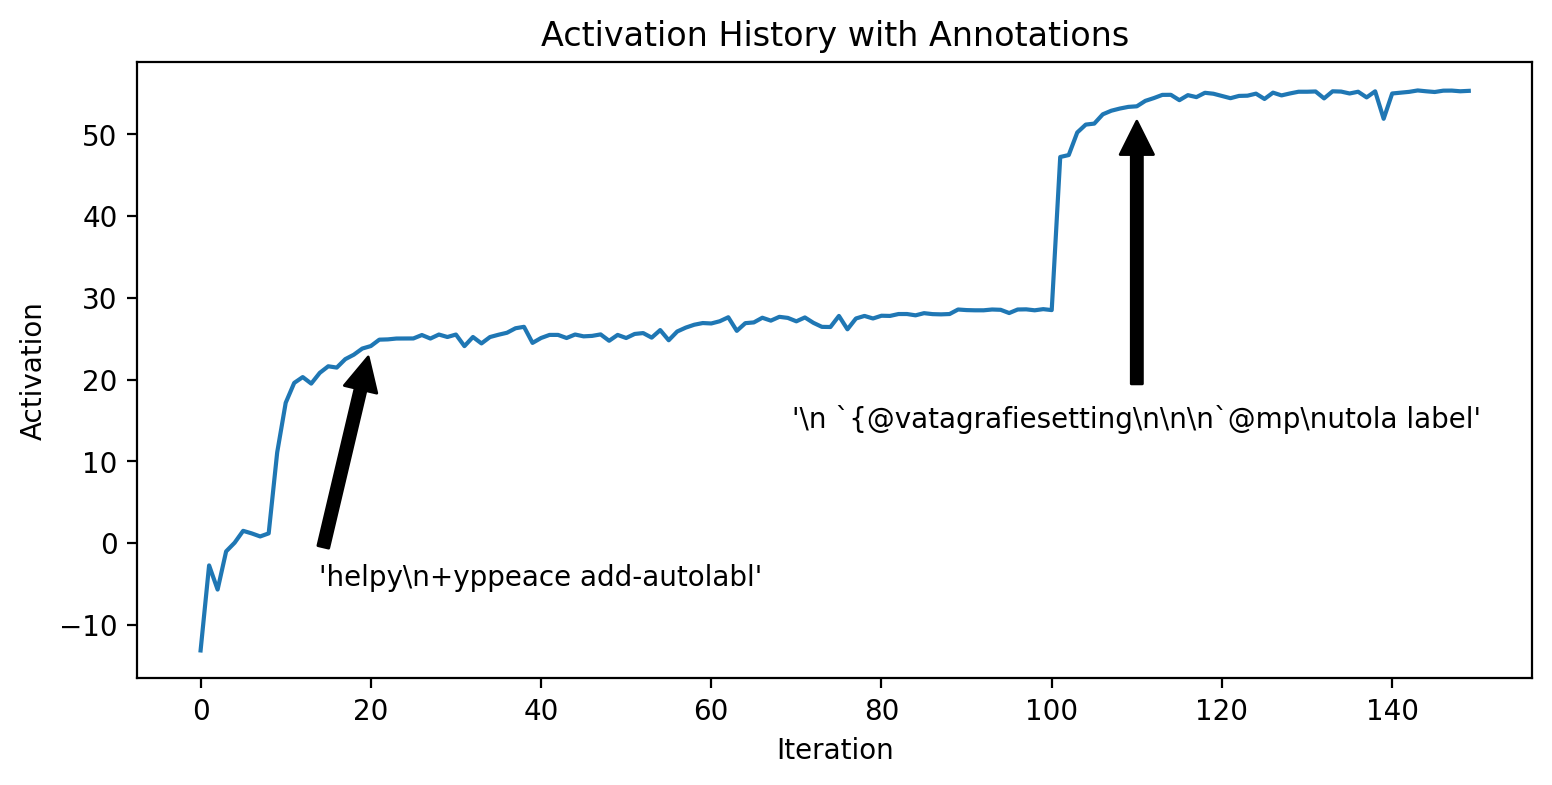

In [39]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(9, 4))
activations = [h["activation"] for h in encoder_history]
plt.plot(activations)
plt.annotate(
    repr(encoder_history[20]["seq"]),
    xy=(20, activations[20]),
    xytext=(40, activations[20] - 30),
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="bottom",
)
plt.annotate(
    repr(encoder_history[110]["seq"]),
    xy=(110, activations[110]),
    xytext=(110, activations[110] - 40),
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="bottom",
)
plt.xlabel("Iteration")
plt.ylabel("Activation")
plt.title("Activation History with Annotations")
plt.show()

## Dreaming decoder directions

Out of curiosity, do we get similar results if we apply feature
visualization to the corresponding decoder direction?

In [40]:
def gemma_sae_decoder(gemma2, layer, feature_idx):
    def f(input_ids=None, inputs_embeds=None, attention_mask=None):
        out = {}

        def get_res(module, input, output):
            out["res"] = input[0]

        model_hooks = [
            (gemma2.model.layers[layer], get_res),
        ]
        with add_fwd_hooks(model_hooks):
            if inputs_embeds is not None:
                logits = gemma2(
                    inputs_embeds=inputs_embeds, attention_mask=attention_mask
                ).logits
            else:
                logits = gemma2(
                    input_ids=input_ids, attention_mask=attention_mask
                ).logits

        def get_sae_pre(module, input, output):
            out["sae_pre"] = input[0]

        sae = load_sae(layer)
        activation = out["res"][:, -1].to(sae.dtype) @ sae.W_dec[feature_idx]

        return activation, logits

    return f

Based on the correlation of 0.99, the answer appears to be an emphatic
yes for this particular feature. However, it might be different for
other features.

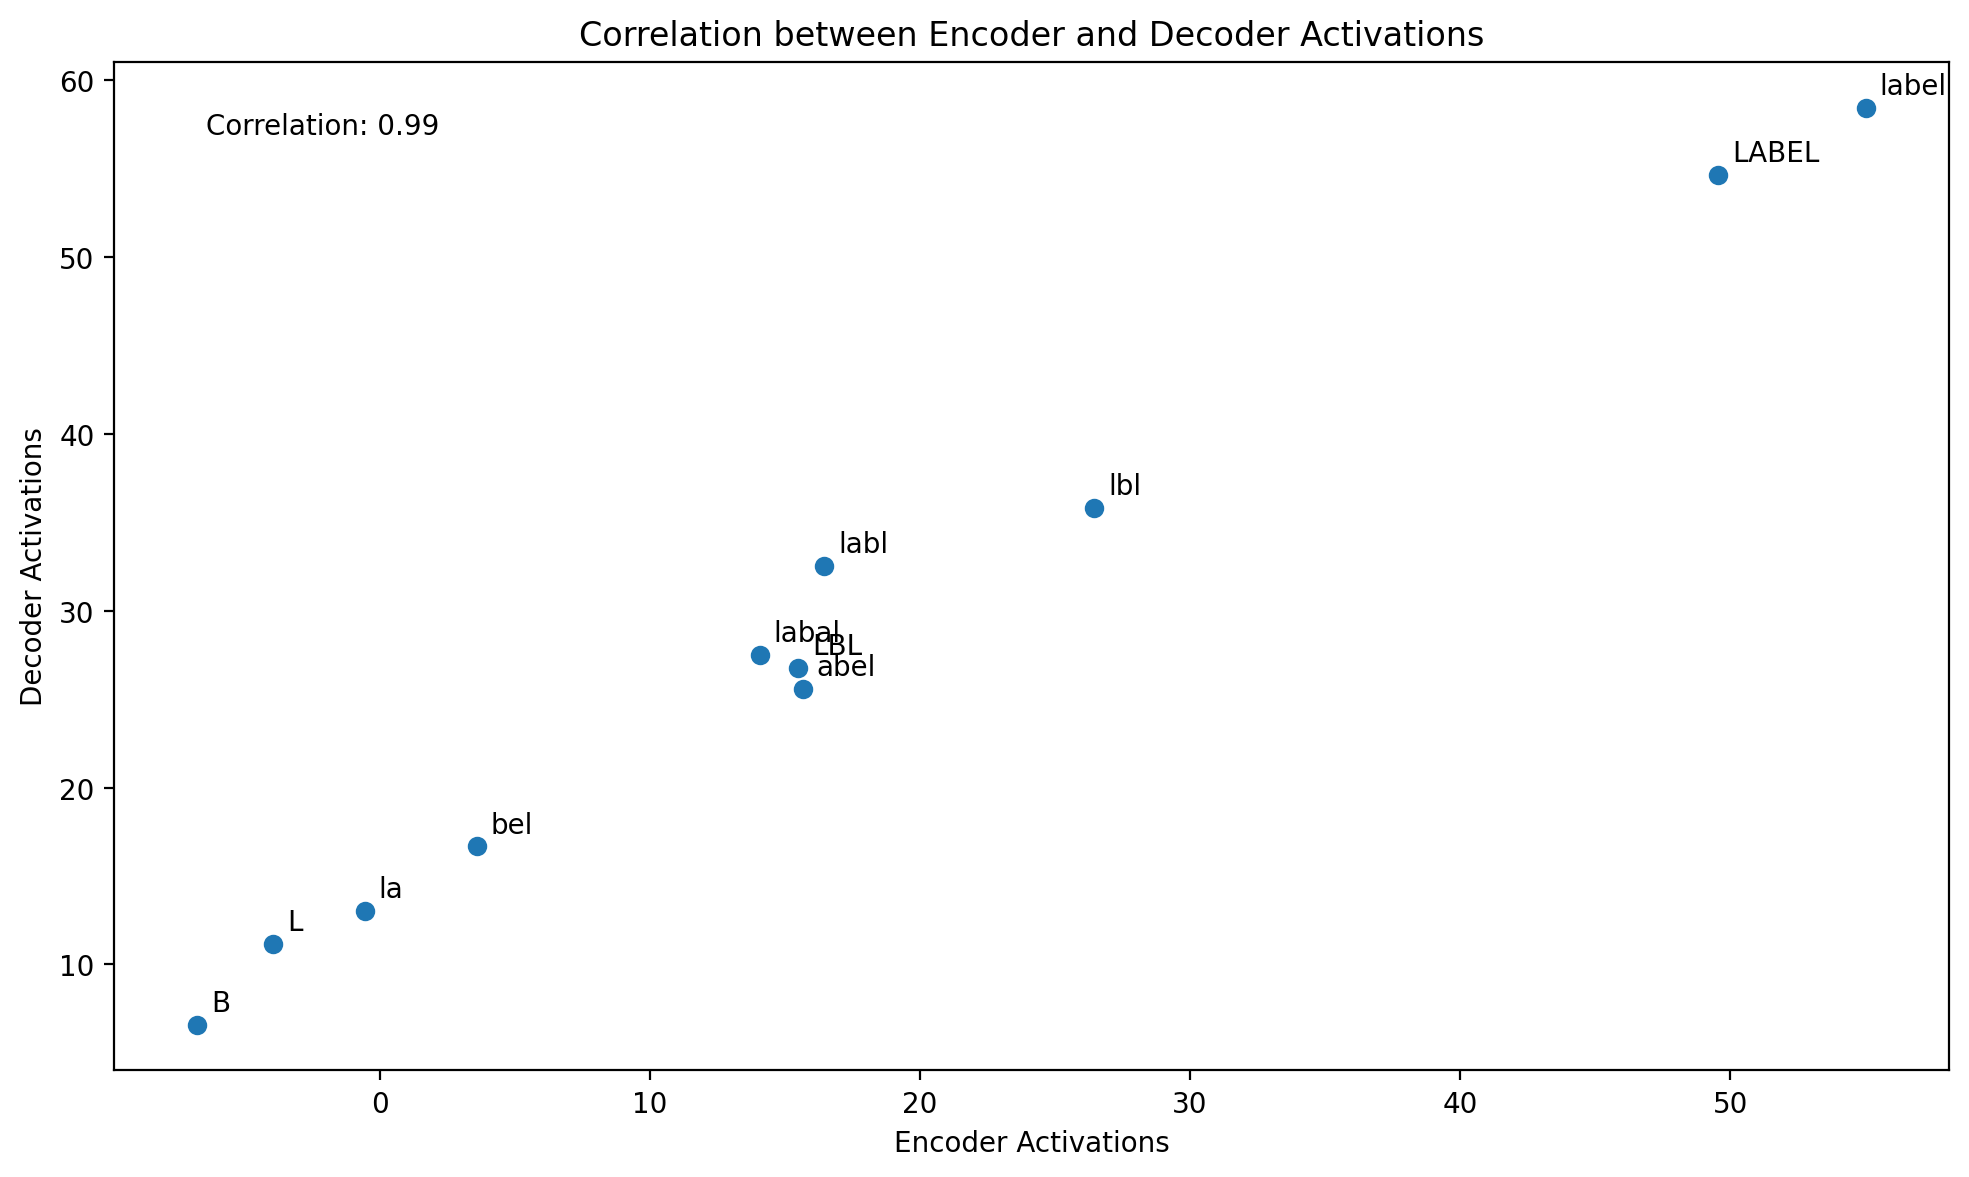

In [41]:
layer = 12
feature_idx = 0
texts = [
    "label",
    "labl",
    "LBL",
    "lbl",
    "LABEL",
    "labal",
    "L",
    "B",
    "bel",
    "la",
    "abel",
]

encoder_activations = []
decoder_activations = []

for text in texts:
    inputs = tokenizer([text], padding=True, return_tensors="pt")
    input_ids = inputs["input_ids"]
    encoder_activation, _ = gemma_sae_encoder(gemma2, layer, feature_idx)(
        input_ids=input_ids
    )
    decoder_activation, _ = gemma_sae_decoder(gemma2, layer, feature_idx)(
        input_ids=input_ids
    )
    encoder_activations.append(encoder_activation.item())
    decoder_activations.append(decoder_activation.item())

plt.figure(figsize=(10, 6))
plt.scatter(encoder_activations, decoder_activations)
plt.xlabel("Encoder Activations")
plt.ylabel("Decoder Activations")
plt.title("Correlation between Encoder and Decoder Activations")

# Add text labels for each point
for i, text in enumerate(texts):
    plt.annotate(
        text,
        (encoder_activations[i], decoder_activations[i]),
        xytext=(5, 5),
        textcoords="offset points",
    )

# Calculate and display correlation coefficient
correlation = np.corrcoef(encoder_activations, decoder_activations)[0, 1]
plt.text(
    0.05,
    0.95,
    f"Correlation: {correlation:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.tight_layout()
plt.show()


Feature visualization on the decoder direction also acquires the “label”
phrase:

In [42]:
decoder_history = dream(
    gemma2,
    tokenizer,
    get_feature_and_logits=gemma_sae_decoder(gemma2, layer, feature_idx),
    iters=150,
    init_prompt="help",
    xe_max=10.0,
)

<span class="csl-left-margin">\[1\]
</span><span class="csl-right-inline">J. Bloom, “Open source sparse
autoencoders for all residual stream layers of GPT2 small.”
<https://www.alignmentforum.org/posts/f9EgfLSurAiqRJySD/open-source-sparse-autoencoders-for-all-residual-stream>,
2024.</span>

<span class="csl-left-margin">\[2\]
</span><span class="csl-right-inline">T. Lieberum *et al.*, “Gemma
scope: Open sparse autoencoders everywhere all at once on gemma 2.”
2024. Available: <https://arxiv.org/abs/2408.05147></span>

<span class="csl-left-margin">\[3\]
</span><span class="csl-right-inline">T. B. Thompson and M. Sklar,
“FLRT: Fluent student-teacher redteaming.” 2024. Available:
<https://arxiv.org/abs/2407.17447></span>